In [1]:
# LIBRARIES

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.over_sampling import ADASYN
from imblearn.combine import SMOTETomek
from imblearn.combine import SMOTEENN
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.model_selection import GridSearchCV, KFold
from sklearn.preprocessing import LabelBinarizer
import sklearn.metrics as met

In [2]:
# DATASET

df = pd.read_excel("DryBeanDataset/Dry_Bean_Dataset.xlsx")
df = df.drop_duplicates(ignore_index=True)
df.rename(columns = {'AspectRation':'AspectRatio'}, inplace = True)
df = df.astype({'Area': 'float64'})
df = df.astype({'Class': 'string'})
df.info()
df.describe() #df[df['Class']=='BOMBAY'].describe()
labels = ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']
colors = ['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink']
features = df.columns.to_list();
features.remove('Class');
#features = ['Area', 'Perimeter', 'MajorAxisLength', 'MinorAxisLength', 'AspectRatio', 'Eccentricity', 'ConvexArea', 'EquivDiameter', 
#            'Extent', 'Solidity', 'roundness', 'Compactness', 'ShapeFactor1', 'ShapeFactor2','ShapeFactor3', 'ShapeFactor4'];



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13543 entries, 0 to 13542
Data columns (total 17 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Area             13543 non-null  float64
 1   Perimeter        13543 non-null  float64
 2   MajorAxisLength  13543 non-null  float64
 3   MinorAxisLength  13543 non-null  float64
 4   AspectRatio      13543 non-null  float64
 5   Eccentricity     13543 non-null  float64
 6   ConvexArea       13543 non-null  int64  
 7   EquivDiameter    13543 non-null  float64
 8   Extent           13543 non-null  float64
 9   Solidity         13543 non-null  float64
 10  roundness        13543 non-null  float64
 11  Compactness      13543 non-null  float64
 12  ShapeFactor1     13543 non-null  float64
 13  ShapeFactor2     13543 non-null  float64
 14  ShapeFactor3     13543 non-null  float64
 15  ShapeFactor4     13543 non-null  float64
 16  Class            13543 non-null  string 
dtypes: float64(1

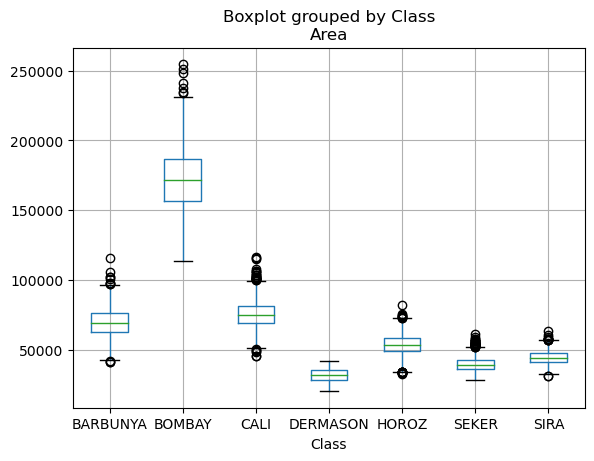

In [3]:
# BOXPLOTS

df.boxplot('Area', by='Class');

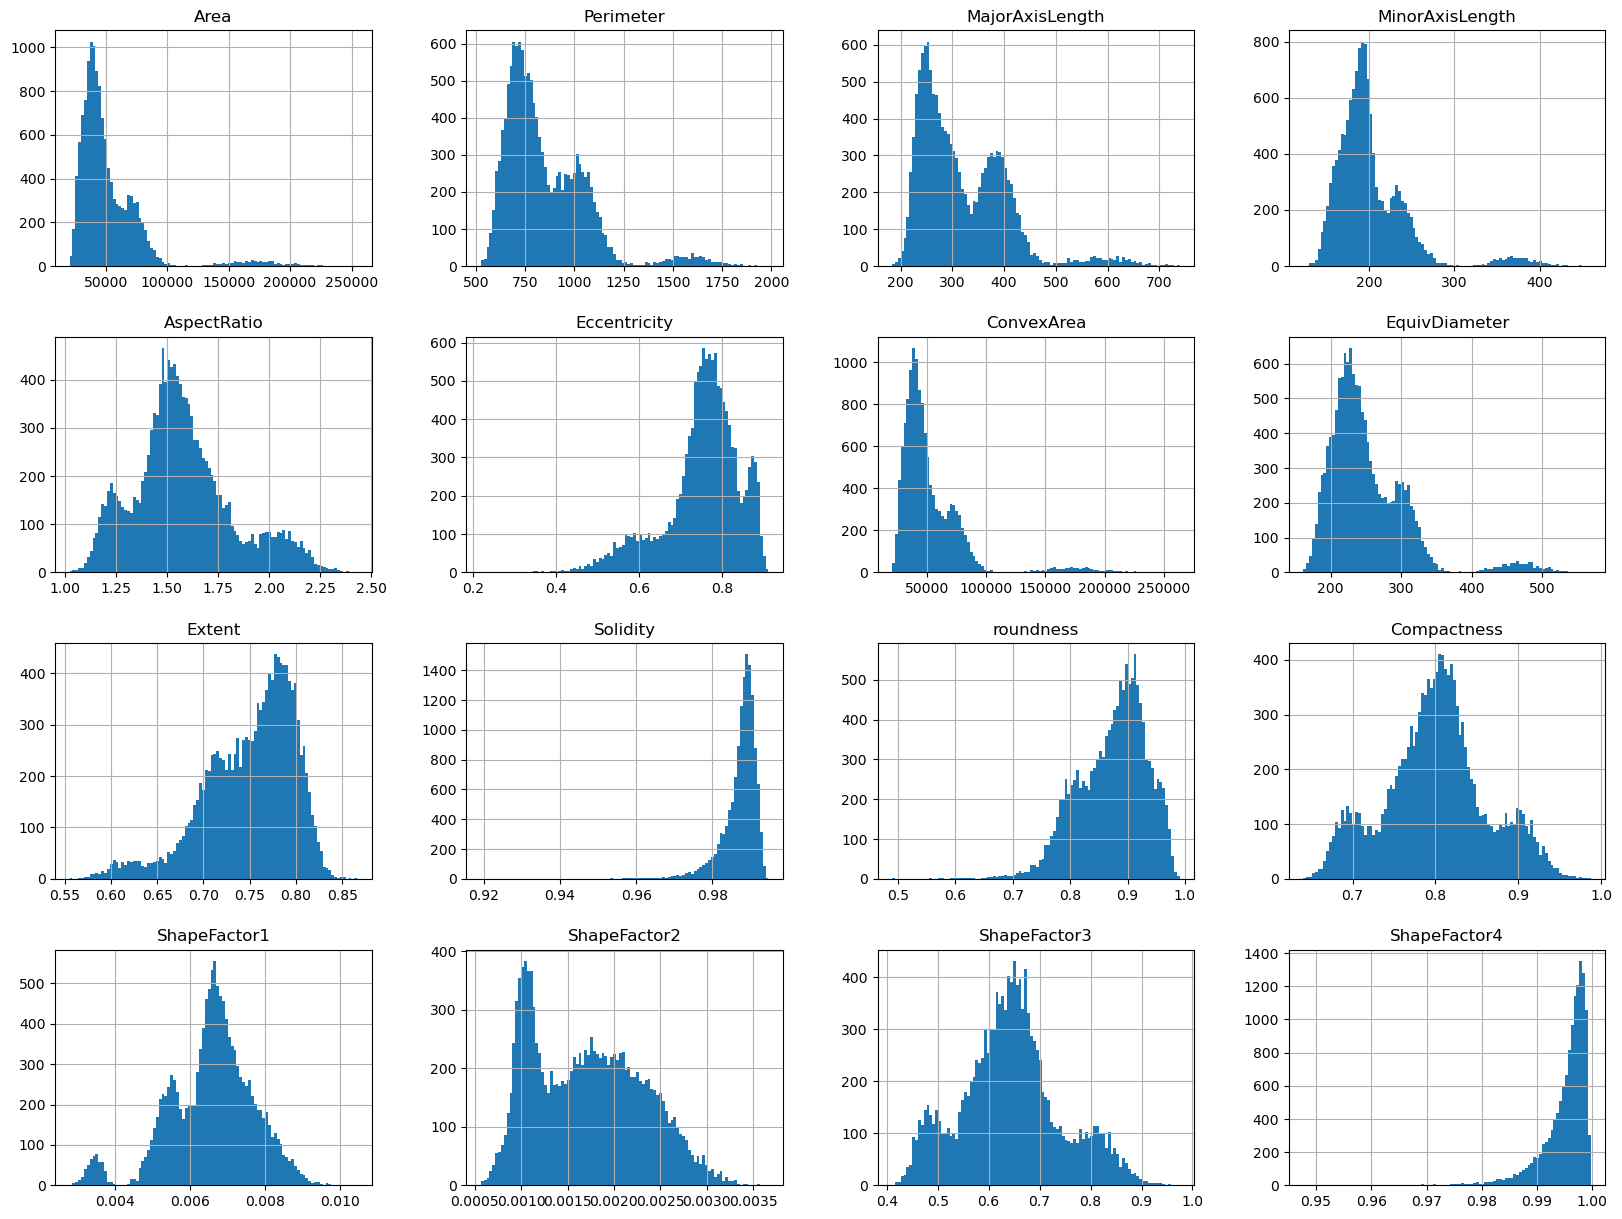

In [4]:
# HISTOGRAMS

df.hist(figsize=(20,15),bins=100); #Note: Through this plot we noticed the first correlations through shape
#df.groupby('Class').hist(figsize=(20,15),bins=100); #Note: It is not informative for our purposes

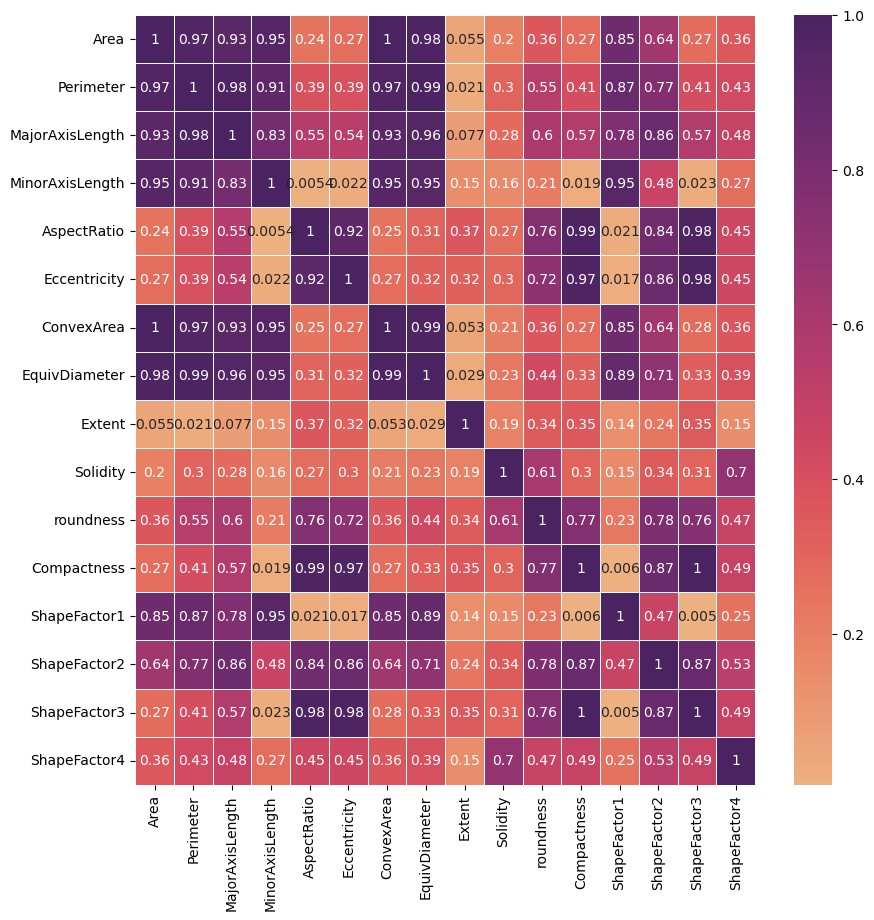

In [5]:
# CORRELATION

fig, ax = plt.subplots(figsize=(10,10)) 
CORR_MAP = df.corr(numeric_only = True).abs()
Steep = 10.0
Stretch = 2.002
if Stretch < 2.0 :
    Stretch = 2.0 
HIGH_CORR = (np.tan((np.pi/Stretch) * np.abs(CORR_MAP)) * (1 / Steep)) #LOW INFORMATION
LOW_CORR  = (np.tan((np.pi/Stretch) * (1 - np.abs(CORR_MAP))) * (1 / Steep)) #HIGH INFORMATION

sns.heatmap( CORR_MAP,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"
#sns.heatmap( HIGH_CORR,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"
#sns.heatmap( LOW_CORR,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"


In [6]:
# ARBITRARY DROPPING BY CORRELATION ANALYSIS
# Note: Area and ConvexArea are almost perfectly correlated: we already noticed that mathematically one is the square root of the other.
# Note: Compactness and Shape Factor 3 are almost perfectly correlated
# Proposition: Erase ConvexArea and Compactness

dfb = df.drop(['ConvexArea','Compactness'], axis=1);
#idx = 6453
#Ed = np.sqrt(4 * df.loc[idx].Area / np.pi);
#Co = Ed / df.loc[idx].MajorAxisLength;
#SF3 = df.loc[idx].Area / (np.pi * (df.loc[idx].MajorAxisLength / 2) * (df.loc[idx].MajorAxisLength / 2));

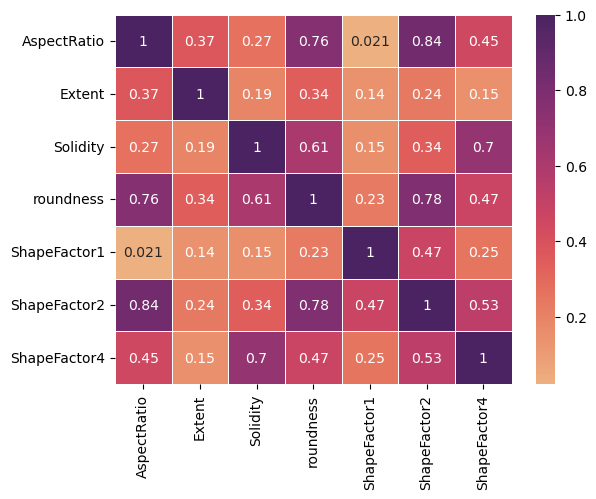

In [7]:
# PRUNING BY CORRELATION

dfc = df
corr = dfc.corr(numeric_only = True).abs()
drop = []
hold = []
p_threshold = 0.9

for i in range(0,corr.shape[0]):
    for j in range(i+1,corr.shape[1]):
        if corr.iloc[i,j]>=p_threshold:
            feature_i_corrsum = corr.iloc[i,:].sum()
            feature_j_corrsum = corr.iloc[j,:].sum()
            if feature_i_corrsum <= feature_j_corrsum:
                #hold.append(corr.index[i])
                #drop.append(corr.index[j])
                hold.append(i)
                drop.append(j)                
            else:
                #drop.append(corr.index[i])
                #hold.append(corr.index[j])
                drop.append(i)
                hold.append(j)

drop = list(set(drop))
drop = [list(corr.index)[i] for i in drop]
dfc = dfc.drop(drop, axis=1) 
corr = dfc.corr(numeric_only = True).abs()
sns.heatmap( corr,annot=True,linewidths=.5, cmap="flare"); # cmap="rocket_r"

In [8]:
# RANDOM FOREST FEATURE IMPORTANCE

dff = df
X = dff.iloc[:,:-1]
y = dff.iloc[:,-1:]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)

rnd_clf = RandomForestClassifier(n_estimators = 512, 
                                 criterion="gini",                      # {"gini", "entropy", "log_loss"}  
                                 min_samples_split = 2,
                                 max_features = "sqrt",                 # {"sqrt", "log2", None}
                                 bootstrap = True,
                                 oob_score = False,
                                 min_samples_leaf = 1, 
                                 max_depth = None
                                 )
rnd_clf.fit(X_train, y_train.values.ravel())

y_pred_rf = rnd_clf.predict(X_test)
#print(met.accuracy_score(y_pred_rf, y_test));

feat_score = rnd_clf.feature_importances_

features_importances = pd.DataFrame(list(zip(features, feat_score)), columns =['features', 'score']);
features_importances = features_importances.sort_values(by=['score'], ascending=False);
features_importances = features_importances.reset_index(drop = True);
No_of_best = 12
if No_of_best < 1 or No_of_best > len(features_importances):
    No_of_best = len(features_importances)
best_features = features_importances.iloc[:No_of_best,0].tolist()
best_features.append('Class')
dfe = df.filter(best_features , axis=1);


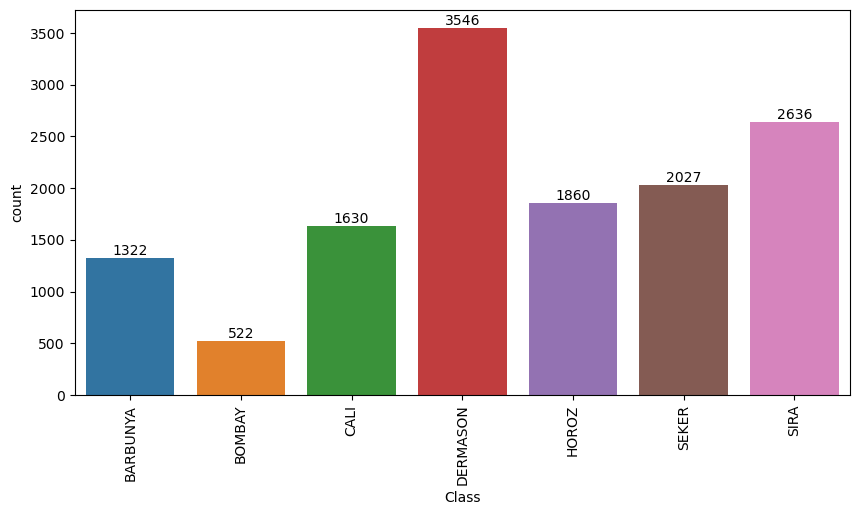

In [9]:
# CLASSES ANALYSIS

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

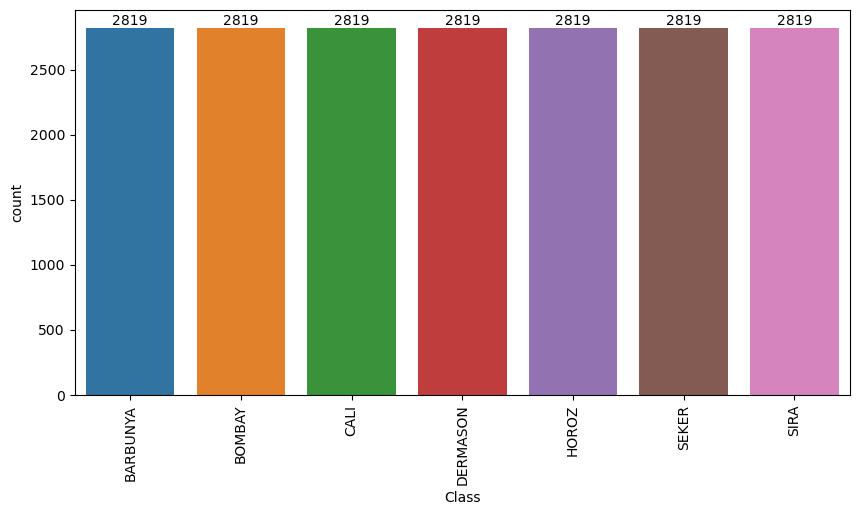

In [10]:
# OVERSAMPLING - SMOTE

X = df.iloc[:,:-1]
y = df.iloc[:,-1:]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)
smt = SMOTE()
X_train_smt, y_train_smt = smt.fit_resample(X_train, y_train)
df_train_smote = pd.merge(X_train_smt, y_train_smt, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df_train_smote, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

# ATTENZIONE, IL NUMERO DI ISTANZE PER CLASSE CAMBIA CONTINUAMENTE, DOPO LO SPLIT LA CLASSE CHE NE ESCE "VINCITRICE",
# LA MAGGIORMENTE SELEZIONA DETERMINA LA SOGLIA DI OVERSAMPLING


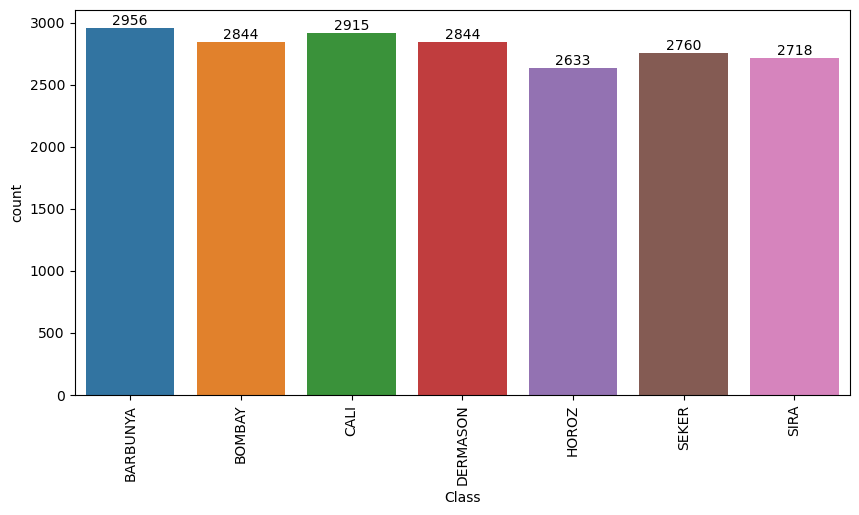

In [11]:
# OVERSAMPLING - ADASYN

X = df.iloc[:,:-1]
y = df.iloc[:,-1:]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)
ada = ADASYN()
X_train_ada, y_train_ada = ada.fit_resample(X_train, y_train)
df_train_adasyn = pd.merge(X_train_ada, y_train_ada, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df_train_adasyn, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

# ATTENZIONE, IL NUMERO DI ISTANZE PER CLASSE CAMBIA CONTINUAMENTE, DOPO LO SPLIT LA CLASSE CHE NE ESCE "VINCITRICE",
# LA MAGGIORMENTE SELEZIONA DETERMINA LA SOGLIA DI OVERSAMPLING

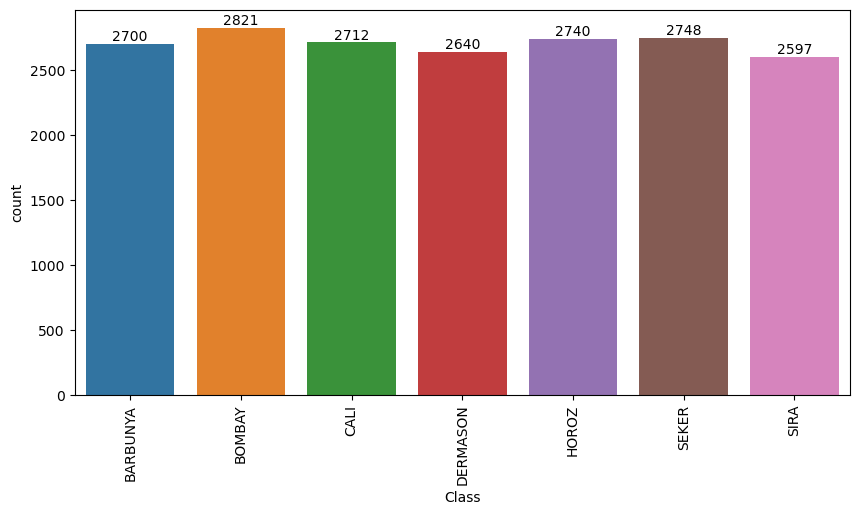

In [12]:
# HYBRIDIZATION - SMOTE+Tomek

X = df.iloc[:,:-1]
y = df.iloc[:,-1:]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)
stk = SMOTETomek()
X_train_stk, y_train_stk = stk.fit_resample(X_train, y_train)
df_train_stomek = pd.merge(X_train_stk, y_train_stk, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df_train_stomek, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

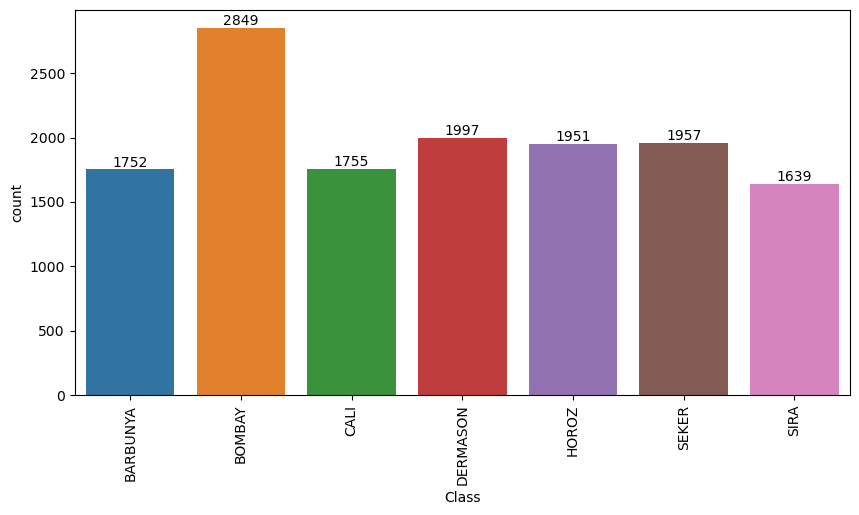

In [13]:
# HYBRIDIZATION - SMOTE+ENN

X = df.iloc[:,:-1]
y = df.iloc[:,-1:]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)
snn = SMOTEENN()
X_train_snn, y_train_snn = snn.fit_resample(X_train, y_train)
df_train_smtenn = pd.merge(X_train_snn, y_train_snn, left_index=True, right_index=True)

fig, ax = plt.subplots(figsize=(10,5))
graph = sns.countplot(ax=ax, x='Class', data=df_train_smtenn, order=labels)
graph.set_xticklabels(graph.get_xticklabels(),rotation=90)
graph.bar_label(ax.containers[0]);

In [14]:
# CLASS BALANCING SCATTERPLOTS

#dfs = [df] # SELECT DATAFRAME: [df, dfb, dfc, dfe, df_train_smote, df_train_adasyn, df_train_stomek, df_train_smtenn]

#for item in dfs:
#    feats = item.columns.to_list();
#    pairs_features = [(a, b) for idx, a in enumerate(feats) for b in feats[idx + 1:]];
#    for pair in pairs_features:
#        plt.subplots(figsize=(10,5));
#        for label in labels:
#            sns.scatterplot(x=pair[0], y=pair[1], data=item[item['Class']==label]);
#            plt.legend(labels, fontsize = 10, loc=0);
    

In [15]:
# ENSEMBLE METHODS

dfr = dfc # SELECT DATAFRAME: [df, dfb, dfc, dfe, df_train_smote, df_train_adasyn, df_train_stomek, df_train_smtenn]
X = dfr.iloc[:,:-1]
y = dfr.iloc[:,-1:]
X_train, X_test, y_train, y_test  = train_test_split(X, y, test_size=0.2)

models = {
    "Random Forest": RandomForestClassifier(
        min_samples_leaf=1, max_depth = None
    ),
    "Extra Trees": ExtraTreesClassifier(
        min_samples_leaf=1, max_depth = None
    ),
}
param_grids = {
    "Random Forest": {"n_estimators": [64], 
                      "criterion": ["gini"],                    # {"gini", "entropy", "log_loss"}
                      "min_samples_split": [2],
                      "max_features": ["sqrt"],                 # {"sqrt", "log2", None}
                      "bootstrap": [True],
                      "oob_score": [False]
                      },
    "Extra Trees":   {"n_estimators": [64], 
                      "criterion": ["gini"],                    # {"gini", "entropy", "log_loss"}
                      "min_samples_split": [2],
                      "max_features": ["sqrt"],                 # {"sqrt", "log2", None}
                      "bootstrap": [False],
                      "oob_score": [False]
                      } 
}

results = []
for name, model in models.items():
    grid_search = GridSearchCV(
        estimator=model,
        param_grid=param_grids[name],
        scoring = 'accuracy',
        n_jobs = None,
        refit = True,        
        cv=KFold(n_splits=4, shuffle=True),
        verbose = 4,
        return_train_score=True,
    ).fit(X_train, y_train.values.ravel())
    result = {"model": name, "cv_results": pd.DataFrame(grid_search.cv_results_)}
    results.append(result)

y_pred_test = grid_search.predict(X_test) #best_estimator_.
#print(met.accuracy_score(y_pred_test, y_test))

Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END bootstrap=True, criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=64, oob_score=False;, score=(train=1.000, test=0.928) total time=   1.3s
[CV 2/4] END bootstrap=True, criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=64, oob_score=False;, score=(train=1.000, test=0.919) total time=   1.2s
[CV 3/4] END bootstrap=True, criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=64, oob_score=False;, score=(train=1.000, test=0.925) total time=   1.2s
[CV 4/4] END bootstrap=True, criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=64, oob_score=False;, score=(train=1.000, test=0.929) total time=   1.1s
Fitting 4 folds for each of 1 candidates, totalling 4 fits
[CV 1/4] END bootstrap=False, criterion=gini, max_features=sqrt, min_samples_split=2, n_estimators=64, oob_score=False;, score=(train=1.000, test=0.924) total time=   0.4s
[CV 2/4] END bootstrap=Fal

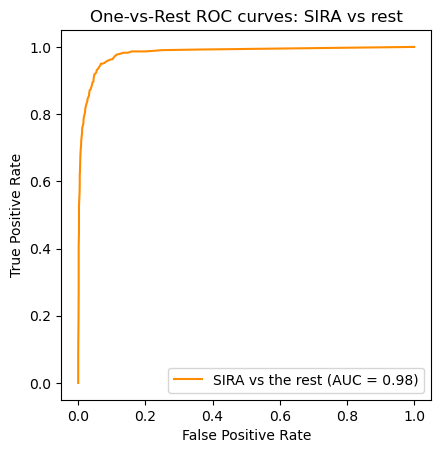

In [16]:
#SCORING

# CLASSES: ['BARBUNYA', 'BOMBAY', 'CALI', 'DERMASON', 'HOROZ', 'SEKER', 'SIRA']

y_score = grid_search.predict_proba(X_test)
label_binarizer = LabelBinarizer().fit(y_train)
y_onehot_test = label_binarizer.transform(y_test)
y_onehot_test.shape  # (n_samples, n_classes)
label_binarizer.transform(["SIRA"])

class_of_interest = "SIRA"
class_id = np.flatnonzero(label_binarizer.classes_ == class_of_interest)[0]
class_id

met.RocCurveDisplay.from_predictions(
    y_onehot_test[:, class_id],
    y_score[:, class_id],
    name=f"{class_of_interest} vs the rest",
    color="darkorange",
    #plot_chance_level=True,
)
plt.axis("square")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("One-vs-Rest ROC curves: " + class_of_interest + " vs rest")
plt.legend()
plt.show()

# FPR = 1 when threshold = 0% or TN = 0
# TPR = 0 when threshold = 1000% or TP = 0